In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1740757550.818798   66194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740757550.822470   66194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740757552.710240   66194 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

# Simulação

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

i_valid_train = pd.Series(train_labels).isin([0,1,2,3,4]).to_numpy()
i_valid_test = pd.Series(test_labels).isin([0,1,2,3,4]).to_numpy()

# Filters to take only the images with labels in [0, 1, 2, 3, 4]
train_images = train_images[i_valid_train]
train_images = train_images / np.max(train_images)
train_shape = train_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
train_images = np.reshape(train_images, (train_shape[0], train_shape[1], train_shape[2], 1))

test_images = test_images[i_valid_test]
test_images = test_images / np.max(test_images)
test_shape = test_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
test_images = np.reshape(test_images, (test_shape[0], test_shape[1], test_shape[2], 1))

train_labels = train_labels[i_valid_train]
test_labels = test_labels[i_valid_test]

In [3]:
def load_file(data_dir, file_index, distribution, train_images, test_images):
    '''
        Example:
            data_dir = "SimulationDataset/Scenario1/n500"
            file_index = 20
            distribution = "poisson"
    '''
    index_path = "{}/indices_{}.csv".format(data_dir, file_index, distribution)
    data_path = "{}/{}/data_{}.csv".format(data_dir, distribution, file_index)
    df_index = pd.read_csv(index_path)
    df_data = pd.read_csv(data_path)

    index_train = df_index.loc[df_index.set == "train","index"].to_numpy()
    index_val = df_index.loc[df_index.set == "val","index"].to_numpy()
    index_test = df_index.loc[df_index.set == "test","index"].to_numpy()

    # Values for the thetas
    theta_train = df_data.loc[df_data.set == "train", "theta"]
    theta_val = df_data.loc[df_data.set == "val", "theta"]
    theta_test = df_data.loc[df_data.set == "test", "theta"]
    # Values for the latent variable
    m_train = df_data.loc[df_data.set == "train", "m"]
    m_val = df_data.loc[df_data.set == "val", "m"]
    m_test = df_data.loc[df_data.set == "test", "m"]
    # Values for the time variable
    t_train = df_data.loc[df_data.set == "train", "t"]
    t_val = df_data.loc[df_data.set == "val", "t"]
    t_test = df_data.loc[df_data.set == "test", "t"]
    # Values for the censorship indicators
    delta_train = df_data.loc[df_data.set == "train", "delta"]
    delta_val = df_data.loc[df_data.set == "val", "delta"]
    delta_test = df_data.loc[df_data.set == "test", "delta"]

    img_train = train_images[index_train,:,:]
    img_val = train_images[index_val,:,:]
    img_test = test_images[index_test,:,:]

    result = {
        "theta_train": theta_train, "theta_val": theta_val, "theta_test": theta_test,
        "m_train": m_train, "m_val": m_val, "m_test": m_test,
        "t_train": t_train, "t_val": t_val, "t_test": t_test,
        "delta_train": delta_train, "delta_val": delta_val, "delta_test": delta_test,
        "img_train": img_train, "img_val": img_val, "img_test": img_test,
        "index_train": index_train, "index_val": index_val, "index_test": index_test
    }
    
    return result

In [4]:
def select_model(distribution, q):
    if(distribution == "poisson"):      
        log_a_str = log_a_poisson_str
        log_phi_str = log_phi_poisson_str
        C_str = C_poisson_str
        C_inv_str = C_inv_poisson_str
        sup_str = sup_poisson_str
        theta_min = None
        theta_max = None
    elif(distribution == "logarithmic"):
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        theta_min = 0
        theta_max = 1
    elif(distribution == "nb" or distribution == "mvnb"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "geometric"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "binomial"): 
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "bernoulli"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "rgp"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "borel"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "geeta"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "haight"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(2, dtype = tf.float64)"
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = 1/2

    return log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max

def fit_cure_model(distribution, q,
                   t_train, t_val,
                   delta_train, delta_val,
                   img_train, img_val,
                   max_iterations = 100,
                   early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
                   epochs = 100, batch_size = None, shuffle = True,
                   learning_rate = 0.001, run_eagerly = False,
                   early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
                   reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
                   verbose = 1, seed = 1):
    alpha0, s_t = initialize_alpha_s(t_train, n_cuts = 5)

    # Select the MPS functions based on the chosen distribution
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)

    set_all_seeds(seed)
    # Because it only serves to initialize the model weights, the distribution does not matter in this case (that's why we use the Poisson here)
    dummy_mps_model = MPScrModel(log_a_poisson_tf, log_phi_poisson_tf, C_poisson_tf, C_inv_poisson_tf, sup_poisson)
    dummy_mps_model.define_structure(shape_input = img_train[0].shape, seed = seed)

    # If batch_size is null, use just one big batch
    if(batch_size is None):
        batch_size = len(t_train)
    
    results = call_EM("EM.py",
                      log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max,
                      dummy_mps_model, alpha0, s_t,
                      img_train, t_train, delta_train, delta_train,
                      max_iterations = max_iterations,
                      early_stopping_em = early_stopping_em, early_stopping_em_warmup = early_stopping_em_warmup, early_stopping_em_eps = early_stopping_em_eps,
                      epochs = epochs, batch_size = batch_size, shuffle = shuffle,
                      learning_rate = learning_rate, run_eagerly = run_eagerly,
                      early_stopping_nn = early_stopping_nn, early_stopping_min_delta_nn = early_stopping_min_delta_nn, early_stopping_patience_nn = early_stopping_patience_nn,
                      reduce_lr = reduce_lr, reduce_lr_steps = reduce_lr_steps, reduce_lr_factor = reduce_lr_factor,
                      validation = True,
                      x_val = img_val, t_val = t_val, delta_val = delta_val, m_val = delta_val,
                      verbose = verbose, seed = seed, alpha_known = False)
    return results

In [5]:
file_info = load_file("SimulationDataset/Scenario1/n500/", 5, "poisson", train_images, test_images)
print( "Keys: {}".format(list(file_info.keys())) )

Keys: ['theta_train', 'theta_val', 'theta_test', 'm_train', 'm_val', 'm_test', 't_train', 't_val', 't_test', 'delta_train', 'delta_val', 'delta_test', 'img_train', 'img_val', 'img_test', 'index_train', 'index_val', 'index_test']


In [6]:
set_all_seeds(10)

sim_results = fit_cure_model("poisson", None,
               file_info["t_train"], file_info["t_val"],
               file_info["delta_train"], file_info["delta_val"],
               file_info["img_train"], file_info["img_val"],
               batch_size = None,
               seed = 1, verbose = 3)

I0000 00:00:1740757553.174753   66194 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
E0000 00:00:1740757554.201877   66304 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740757554.205562   66304 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740757556.512444   66304 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4114 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1740757556.533938   66304 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4114 MB memory:  -> devi

Iniciando passo 1


I0000 00:00:1740757558.277725   66368 cuda_dnn.cc:529] Loaded cuDNN version 90300
 60%|██████    | 60/100 [00:04<00:03, 13.33epoch/s, loss=0.862, loss_val=0.876]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 9.783173118249887e-05
Distância Parâmetros Alpha: 0.4754465869941093
Média das distâncias: 0.2377722093626459
Iniciando passo 2


 14%|█▍        | 14/100 [00:01<00:08,  9.84epoch/s, loss=0.931, loss_val=0.942]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 4.825239133379052e-06
Distância Parâmetros Alpha: 0.09317622394893556
Média das distâncias: 0.04659052459403447
Iniciando passo 3


 13%|█▎        | 13/100 [00:01<00:09,  9.38epoch/s, loss=0.921, loss_val=0.942]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 2.747400388672124e-06
Distância Parâmetros Alpha: 0.028713050638850896
Média das distâncias: 0.014357899019619784
Iniciando passo 4


 59%|█████▉    | 59/100 [00:03<00:02, 15.75epoch/s, loss=0.843, loss_val=0.901]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 6.498849809877411e-05
Distância Parâmetros Alpha: 0.011512664198400748
Média das distâncias: 0.005788826348249761
Iniciando passo 5


  6%|▌         | 6/100 [00:00<00:15,  6.02epoch/s, loss=0.82, loss_val=0.888] 


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 8.706520850797498e-07
Distância Parâmetros Alpha: 0.0019513500857853896
Média das distâncias: 0.0009761103689352347
Iniciando passo 6


 18%|█▊        | 18/100 [00:01<00:07, 11.26epoch/s, loss=0.572, loss_val=0.691]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 5.1897401069396755e-06
Distância Parâmetros Alpha: 0.041335709764650154
Média das distâncias: 0.020670449752378545
Iniciando passo 7


 27%|██▋       | 27/100 [00:01<00:05, 13.83epoch/s, loss=0.559, loss_val=0.697]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 9.522567229167443e-06
Distância Parâmetros Alpha: 0.00613092904205016
Média das distâncias: 0.0030702258046396637
Iniciando passo 8


  6%|▌         | 6/100 [00:01<00:16,  5.64epoch/s, loss=0.605, loss_val=0.756]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 8.991370993531051e-07
Distância Parâmetros Alpha: 0.0015523693378173755
Média das distâncias: 0.0007766342374583643
Iniciando passo 9


 13%|█▎        | 13/100 [00:01<00:08, 10.60epoch/s, loss=0.738, loss_val=0.834]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 1.6975343971227988e-06
Distância Parâmetros Alpha: 0.02658425402816415
Média das distâncias: 0.013292975781280636
Iniciando passo 10


 15%|█▌        | 15/100 [00:01<00:07, 11.09epoch/s, loss=0.698, loss_val=0.813]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 2.625293998941561e-06
Distância Parâmetros Alpha: 0.00227007333923071
Média das distâncias: 0.0011363493166148258
Learning rate reduzida para 0.0001
Iniciando passo 11


  7%|▋         | 7/100 [00:00<00:12,  7.19epoch/s, loss=0.715, loss_val=0.82] 


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 2.713046700183406e-08
Distância Parâmetros Alpha: 0.0009972114516320241
Média das distâncias: 0.000498619291049513
Iniciando passo 12


  6%|▌         | 6/100 [00:00<00:14,  6.61epoch/s, loss=0.692, loss_val=0.804]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.914601093033608e-09
Distância Parâmetros Alpha: 0.000395991756708715
Média das distâncias: 0.00019799983565490403
Iniciando passo 13


  6%|▌         | 6/100 [00:00<00:15,  6.18epoch/s, loss=0.677, loss_val=0.793]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.578367789042472e-09
Distância Parâmetros Alpha: 0.00023220723566997952
Média das distâncias: 0.00011610740701888429
Iniciando passo 14


  6%|▌         | 6/100 [00:00<00:14,  6.59epoch/s, loss=0.664, loss_val=0.785]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.475727836579453e-09
Distância Parâmetros Alpha: 0.00017127471507757453
Média das distâncias: 8.564109540270555e-05
Iniciando passo 15


  6%|▌         | 6/100 [00:00<00:14,  6.52epoch/s, loss=0.657, loss_val=0.779]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.471907117449361e-09
Distância Parâmetros Alpha: 9.659294383323941e-05
Média das distâncias: 4.830020787017843e-05
Iniciando passo 16


  6%|▌         | 6/100 [00:00<00:14,  6.61epoch/s, loss=0.648, loss_val=0.773]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.4294114243650395e-09
Distância Parâmetros Alpha: 8.552648289855733e-05
Média das distâncias: 4.2766956154990846e-05
Iniciando passo 17


  9%|▉         | 9/100 [00:01<00:13,  6.98epoch/s, loss=0.643, loss_val=0.771]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.907644115947359e-08
Distância Parâmetros Alpha: 3.59169549615956e-05
Média das distâncias: 1.7998015701377535e-05
Iniciando passo 18


  6%|▌         | 6/100 [00:00<00:14,  6.58epoch/s, loss=0.636, loss_val=0.765]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.532564772418442e-09
Distância Parâmetros Alpha: 1.718690807929569e-05
Média das distâncias: 8.597220322034054e-06
Iniciando passo 19


  7%|▋         | 7/100 [00:00<00:12,  7.23epoch/s, loss=0.624, loss_val=0.757]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 1.661228425509255e-08
Distância Parâmetros Alpha: 8.745078005087154e-05
Média das distâncias: 4.373369616756332e-05
Iniciando passo 20


  7%|▋         | 7/100 [00:00<00:12,  7.25epoch/s, loss=0.619, loss_val=0.754]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 2.573163677900731e-08
Distância Parâmetros Alpha: 2.8473723153711975e-05
Média das distâncias: 1.4249727395245491e-05
Learning rate reduzida para 1e-05
Iniciando passo 21


  7%|▋         | 7/100 [00:00<00:12,  7.43epoch/s, loss=0.615, loss_val=0.749]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 2.953472936554293e-10
Distância Parâmetros Alpha: 2.5078736472249697e-05
Média das distâncias: 1.2539515909771677e-05
Iniciando passo 22


  6%|▌         | 6/100 [00:00<00:14,  6.54epoch/s, loss=0.614, loss_val=0.749]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.347896559322428e-11
Distância Parâmetros Alpha: 9.332023377593406e-06
Média das distâncias: 4.6660484282794995e-06
Iniciando passo 23


  6%|▌         | 6/100 [00:00<00:14,  6.56epoch/s, loss=0.614, loss_val=0.749]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.349158258972025e-11
Distância Parâmetros Alpha: 4.739870788578265e-06
Média das distâncias: 2.3699721400804274e-06
Iniciando passo 24


  6%|▌         | 6/100 [00:00<00:15,  6.09epoch/s, loss=0.613, loss_val=0.748]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.351732053445487e-11
Distância Parâmetros Alpha: 2.502665477224547e-06
Média das distâncias: 1.2513694972725407e-06
Iniciando passo 25


  6%|▌         | 6/100 [00:00<00:14,  6.47epoch/s, loss=0.613, loss_val=0.748]


Iniciando treinamento:
Tamanho da amostra de treino: 500
Tamanho da amostra de validação: 108
Distância Parâmetros Rede Neural: 7.34790930570058e-11
Distância Parâmetros Alpha: 1.4666129907326824e-06
Média das distâncias: 7.333432349128697e-07
Algoritmo convergiu após 25 iterações. Retornando.
Número de arquivos no diretório: 25


In [7]:
alpha0, s_t = initialize_alpha_s(file_info["t_train"], n_cuts = 5)

alpha estimado: [0.90403162 0.89662829 0.92898258 0.86847408 0.74977768 1.        ]
alpha xie: [1 1 1 1 1 1]


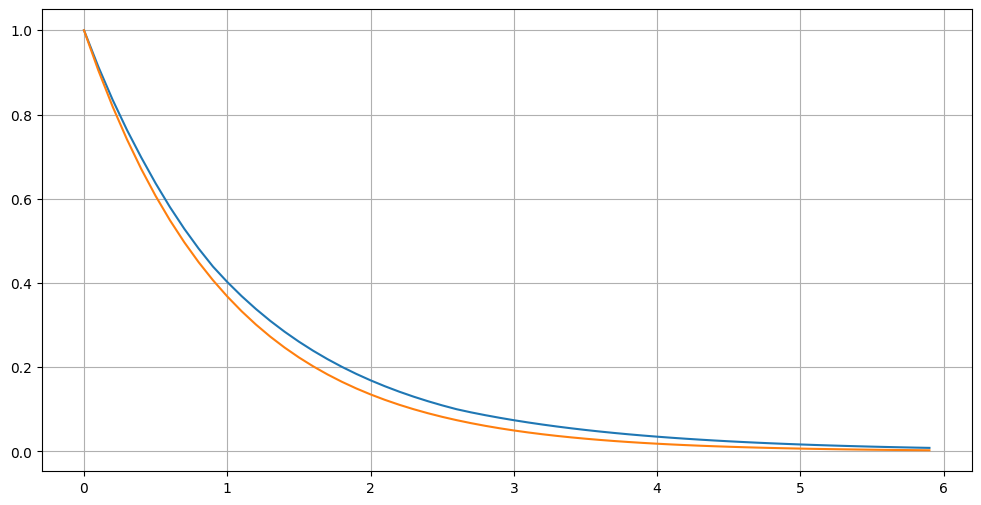

In [8]:
tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, sim_results["alpha_history"][-1], s_t)

alpha_xie = np.array([1, 1, 1, 1, 1, 1])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(sim_results["alpha_history"][-1]))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.grid()
plt.show()

In [9]:
eta_pred_train = sim_results["new_model"].predict(file_info["img_train"])
eta_pred_test = sim_results["new_model"].predict(file_info["img_test"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step

I0000 00:00:1740757606.007143   66268 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [10]:
print("MAE M - train: {}".format( np.mean( np.abs(file_info["m_train"].to_numpy() - sim_results["m_history"][-1])) ))
print("MAE M - test: {}".format( np.mean( np.abs(file_info["m_test"].to_numpy() - sim_results["m_val_history"][-1])) ))

MAE M - train: 0.6700095028670104
MAE M - test: 1.2041034476067187


# Proper simulations

In [1]:
###### import os, shutil
from pathlib import Path

print("Creating directories structure")
dists_scenario1 = ["poisson", "logarithmic", "geometric", "mvnb2", "bernoulli", "bin5", "rgp10"]
dists_scenario2 = ["borel", "rgp2", "haight", "geeta3"]
for dist in dists_scenario1:
    for j in range(1,101):
        Path("SimulationResults/Scenario1/n500/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario1/n1000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario1/n3000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
for dist in dists_scenario2:
    for j in range(1,101):
        Path("SimulationResults/Scenario2/n500/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario2/n1000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario2/n3000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)

Creating directories structure


Below, there is a list of everything that will be saved in each simulation. We must consider the disk space this process might cost us.

For each simulation, we will save:
* Last estimated weights of the fitted model neural network
* For all individuals from the dataset (train, val and test), saves a table with
    * Estimated cure probability $\widehat{p}$
    * Estimated $\widehat{\theta}$
    * Estimated $\widehat{m}$ value
    * Estimated $\widehat{\alpha}$
    * Estimated $s_t$ from the knots of the piecewise exponential (depends on the quantiles of the lifetime observations)
    * Set of the individual (train, val or test)

Note that the real values for each individual is already accounted for in the original simulated dataset. After all simulations, we will compare the real values from the simulated datasets with the estimations saved from these simulations. With this set of informations, we can compute every prediction of interest for each individual, including the estimated AUC metric for the cured ones.

In order to get some more information on the general scenario, we will also save the execution times for each dataset, the final loss function value after training, if the algorithm converged or not and the number of steps the EM needed.

In [14]:
def run_scenario(data_dir, distribution, q, train_images, test_images, start_index = 1, seed = 1):
    '''
        Example:
            data_dir = "SimulationDataset/Scenario1/n500"
            distribution = "poisson"
    '''

    # The name of the distribution does not have any numbers. Simulations like the RPG which are considered for two different values of q have different numbers associated to their directory, which must be conserved for the function to know where to save the files. But for selection of the model in select_model, we must use only "rgp"
    distribution_name = ''.join([i for i in distribution if not i.isdigit()])
    
    # Select the functions associated to the chosen distribution model
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution_name, q)
    log_a_tf = eval(log_a_str)
    log_phi_tf = eval(log_phi_str)
    C_tf = eval(C_str)
    C_inv_tf = eval(C_inv_str)
    sup_tf = eval(sup_str)
    
    execution_times = []
    loss_values = []
    loss_val_values = []
    converged = []
    steps = []
    for i in tqdm(range(start_index, 2)):
        # Load the simulated dataset
        sim_dataset = load_file(data_dir, i, distribution, train_images, test_images)
        
        _, s_t = initialize_alpha_s(sim_dataset["t_train"], n_cuts = 5)
        start_time = time()
        result = fit_cure_model(distribution_name, q,
                                sim_dataset["t_train"], sim_dataset["t_val"],
                                sim_dataset["delta_train"], sim_dataset["delta_val"],
                                sim_dataset["img_train"], sim_dataset["img_val"],
                                batch_size = None, max_iterations = 100,
                                seed = seed, verbose = 0)
        elapsed_time = time() - start_time
        execution_times.append(elapsed_time)
        
        # Recover information on the inference of parameters
        eta_train_pred = result["new_model"].predict(sim_dataset["img_train"], verbose = 0)
        eta_val_pred = result["new_model"].predict(sim_dataset["img_val"], verbose = 0)
        eta_test_pred = result["new_model"].predict(sim_dataset["img_test"], verbose = 0)
        
        p_train_pred = result["new_model"].link_func(eta_train_pred).numpy().flatten()
        p_val_pred = result["new_model"].link_func(eta_val_pred).numpy().flatten()
        p_test_pred = result["new_model"].link_func(eta_test_pred).numpy().flatten()
        p_pred = np.concatenate([p_train_pred, p_val_pred, p_test_pred])
        
        log_p_train_pred = np.log(p_train_pred)
        log_p_val_pred = np.log(p_val_pred)
        log_p_test_pred = np.log(p_test_pred)
        
        log_a0 = log_a_tf( tf.constant(0.0, dtype = tf.float64) )
        
        theta_train_pred = C_inv_tf( np.exp(log_a0 - log_p_train_pred) ).numpy()
        theta_val_pred = C_inv_tf( np.exp(log_a0 - log_p_val_pred) ).numpy()
        theta_test_pred = C_inv_tf( np.exp(log_a0 - log_p_test_pred) ).numpy()
        theta_pred = np.concatenate([theta_train_pred, theta_val_pred, theta_test_pred])
        
        m_train_pred = result["m_history"][-1]
        m_val_pred = result["m_val_history"][-1]
        m_test_pred = update_m_mps(result["new_model"], result["new_alpha"], s_t, sim_dataset["img_test"], sim_dataset["t_test"], sim_dataset["delta_test"])
        m_pred = np.concatenate([m_train_pred, m_val_pred, m_test_pred])

        sets = np.concatenate([np.repeat("train", len(theta_train_pred)), np.repeat("val", len(theta_val_pred)), np.repeat("test", len(theta_test_pred))])

        results_dir = data_dir.split("/")
        results_dir = "{}/{}".format("SimulationResults", "/".join(results_dir[1:]))
        # pd.DataFrame({"p_pred": p_pred, "theta_pred": theta_pred, "m_pred": m_pred, "set": sets}).to_csv(
        #     "{}/{}/{}/data_pred.csv".format(results_dir, distribution, i), index = False
        # )
        
        # Save the model weights
        # result["new_model"].save_model("{}/{}/{}/model.weights.h5".format(results_dir, distribution, i))

        # Save the piecewise exponential estimated parameters
        # save_alpha_s(result["new_alpha"], s_t, filename = "{}/{}/{}/alpha_s.csv".format(results_dir, distribution, i))

        loss_values.append( result["loss_history"][-1] )
        loss_val_values.append( result["loss_val_history"][-1] )
        converged.append( result["converged"] )
        steps.append( result["steps"] )

    # pd.DataFrame({"execution_times": execution_times, "loss_values": loss_values, "loss_val_values": loss_val_values, "converged": converged, "steps": steps}).to_csv(
    #     "{}/{}/sim_metadata.csv".format(results_dir, distribution, i), index = False
    # )

In [15]:
run_scenario("SimulationDataset/Scenario1/n500", "poisson", None, train_images, test_images, seed = 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:52<00:00, 52.29s/it]


Now that everything is working, we just need to pass all this code to a .py file so we can execute multiple simulations at once. We note that the GPU memory is used only partially with each simulation scenario. We would like to verify if an entire distribution scenario (for example, poisson for n500, n1000 and n3000) may be executed all at once.

In [33]:
sup_rgp(-1/10)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [69]:
log_a_0 = log_a_rgp(-1/10)(tf.constant(0.0, dtype = tf.float64))
log_p_0 = np.log(0.000005)
C_inv_rgp(-1/10)( np.exp( log_a_0 - log_p_0 ) )

np.float64(12.206072645530174)

# Teste

alpha estimado: [1.5596694  1.23402632 1.43846436 0.75096684 0.         1.        ]
alpha xie: [1 1 1 1 1 1]


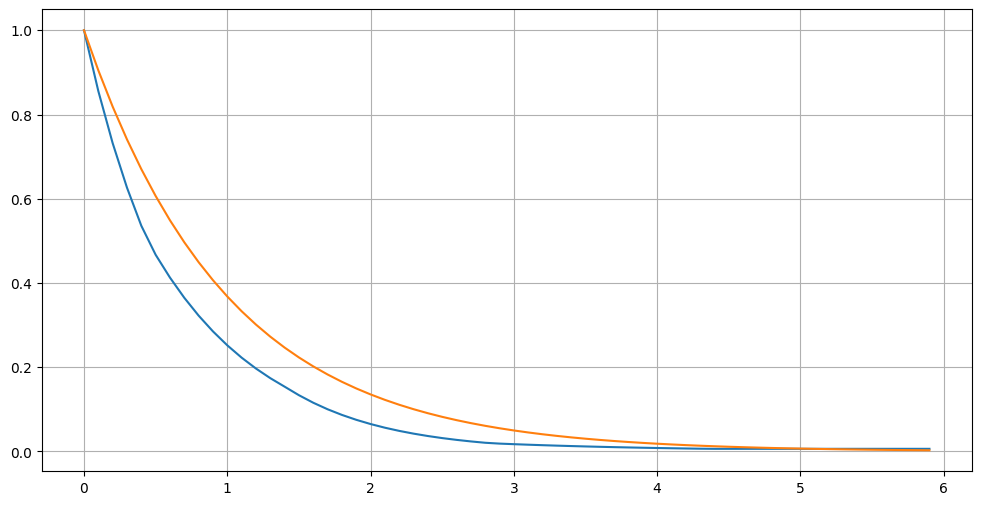

In [112]:
data = pd.read_csv("SimulationResults/Scenario2/n3000/geeta3/30/alpha_s.csv")
alpha = data.alpha.to_numpy()
s_t = data.s.to_numpy()

tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, alpha, s_t)

alpha_xie = np.array([1, 1, 1, 1, 1, 1])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(alpha))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.grid()
plt.show()

In [90]:
def plot_S1(n, scenario, distribution, ax = None, title = ""):
    if(ax is None):
        fig, ax = plt.subplots(figsize = (12, 6))
    
    for i in range(1, 101):
        data = pd.read_csv("SimulationResults/Scenario{}/n{}/{}/{}/alpha_s.csv".format(scenario, n, distribution, i))
        
        if(i == 1):
            s_t = data.s.to_numpy()
            tv = np.arange(0, s_t[-1], 0.1)

            alpha = data.alpha.to_numpy()
            S1i = S1(tv, alpha, s_t)
            S1_mean = S1i.copy()
    
            # Initialize the table with all estimated survival curves
            S1i_table = np.zeros((100, len(S1_mean)))
            S1i_table[0,:] = S1_mean
            
            alpha_xie = np.array([1, 1, 1, 1, 1, 1])
            S1v_xie = S1i.copy()
        else:
            alpha = data.alpha.to_numpy()
            S1i = S1(tv, alpha, s_t)
            
            S1i_table[i-1,:] = S1i
            if( not np.isnan(S1i).any() ):
                S1_mean += S1i

        ax.plot(tv, S1i, color = "black", alpha = 0.1)
    
    # Get the indices for which the simulation did not converge
    nan_indices = np.unique( np.where( np.isnan(S1i_table) )[0] )
    if(len(nan_indices) > 0):
        print("n = {} - {}: Simulações {} não obtiveram convergência!".format(n, distribution, nan_indices))
    # Remove the nan observations from the table
    S1i_table = np.delete(S1i_table, nan_indices, axis = 0)
    
    S1q95 = np.quantile(S1i_table, 0.95, axis = 0)
    S1q05 = np.quantile(S1i_table, 0.05, axis = 0)
    S1_mean = S1_mean / S1i_table.shape[0]
    
    ax.plot(tv, S1v_xie, color = "black", linewidth = 2)

    ax.plot(tv, S1q95, color = "red", linestyle = "dashed")
    ax.plot(tv, S1q05, color = "red", linestyle = "dashed")
    ax.plot(tv, S1_mean, color = "red", linewidth = 2)

    ax.set_title(title)

Poisson
Logarithmic
MVNB
n = 500 - mvnb2: Simulações [34] não obtiveram convergência!
n = 1000 - mvnb2: Simulações [36] não obtiveram convergência!


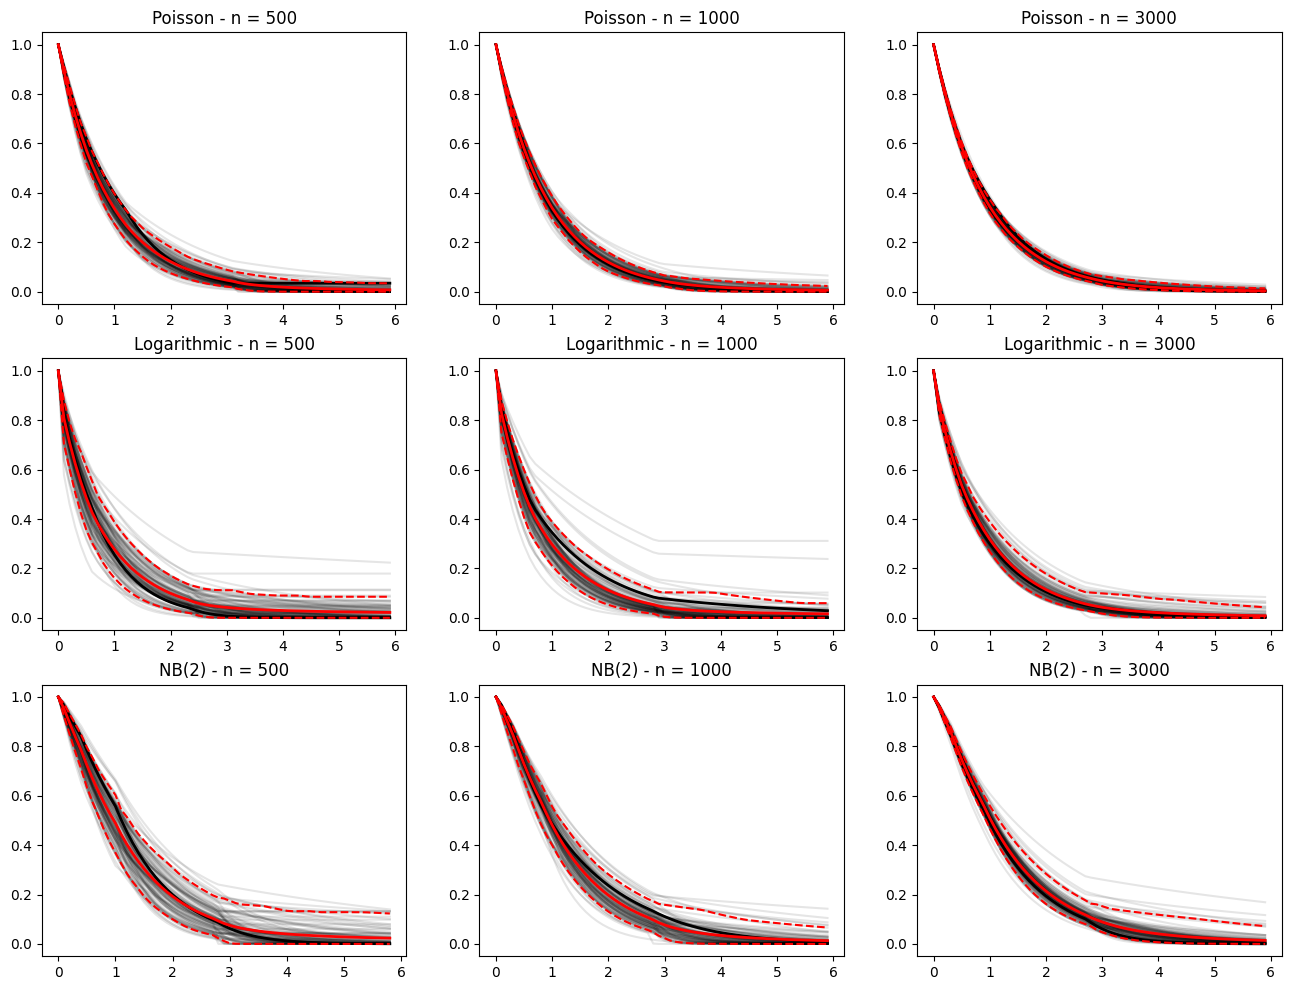

In [6]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (16,12))

print("Poisson")
plot_S1(500, 1, "poisson", ax[0,0], "Poisson - n = 500")
plot_S1(1000, 1, "poisson", ax[0,1], "Poisson - n = 1000")
plot_S1(3000, 1, "poisson", ax[0,2], "Poisson - n = 3000")

print("Logarithmic")
plot_S1(500, 1, "logarithmic", ax[1,0], "Logarithmic - n = 500")
plot_S1(1000, 1, "logarithmic", ax[1,1], "Logarithmic - n = 1000")
plot_S1(3000, 1, "logarithmic", ax[1,2], "Logarithmic - n = 3000")

print("MVNB")
plot_S1(500, 1, "mvnb2", ax[2,0], "NB(2) - n = 500")
plot_S1(1000, 1, "mvnb2", ax[2,1], "NB(2) - n = 1000")
plot_S1(3000, 1, "mvnb2", ax[2,2], "NB(2) - n = 3000")

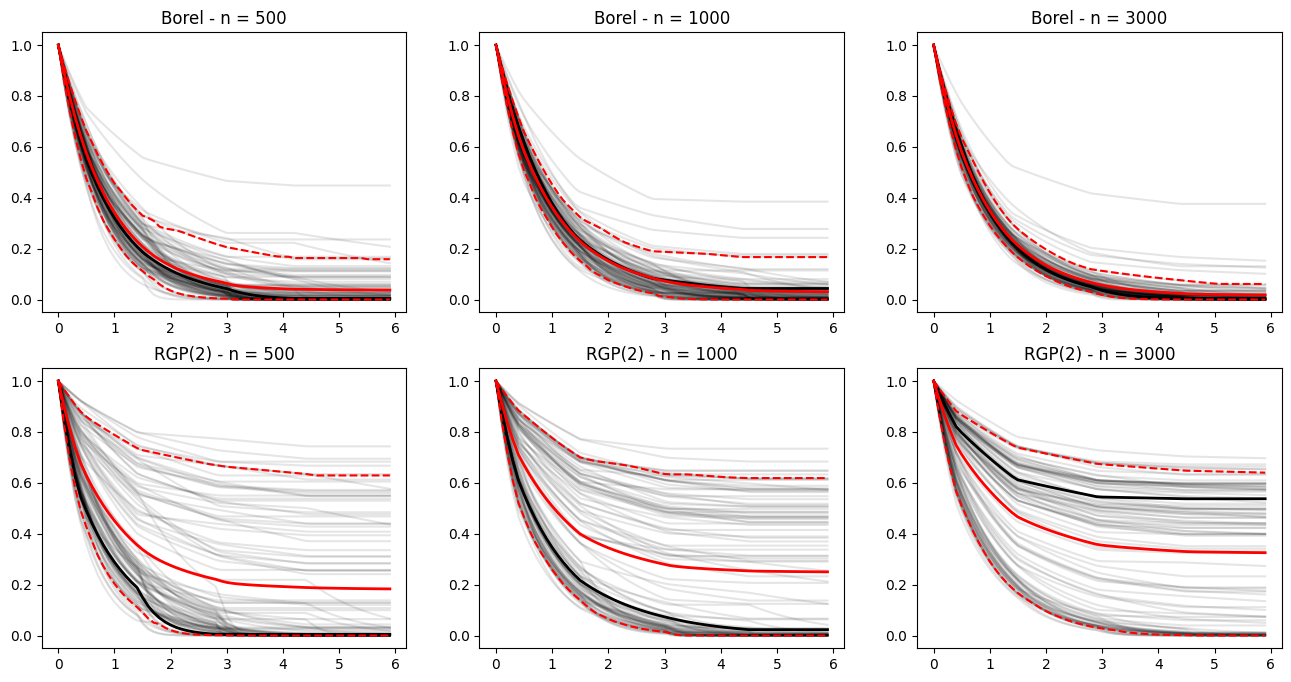

In [91]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16,8))

plot_S1(500, 2, "borel", ax[0,0], "Borel - n = 500")
plot_S1(1000, 2, "borel", ax[0,1], "Borel - n = 1000")
plot_S1(3000, 2, "borel", ax[0,2], "Borel - n = 3000")

plot_S1(500, 2, "rgp2", ax[1,0], "RGP(2) - n = 500")
plot_S1(1000, 2, "rgp2", ax[1,1], "RGP(2) - n = 1000")
plot_S1(3000, 2, "rgp2", ax[1,2], "RGP(2) - n = 3000")